<a href="https://colab.research.google.com/github/JohnOngeri/FraudDetection/blob/main/Summative_Intro_to_ml_%5BJohn_Ongeri_Ouma_number%5D_assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Optimization Techniques in Machine Learning

Objective: This assignment aims to explore implementation or Machine Learning Models with regularization, optimization and Error analysis  techniques used in machine learning to improve models' performance, convergence speed, and efficiency..

A Notebook detailing the following

* Project name
* Clear out puts from cells






**Instructions**

1. Acquire a dataset suitable for ML tasks as per your proposal.
2. Implement a simple machine learning model based on neural networks on the chosen dataset without any defined optimization techniques. (Check instructions)
3. Implement and compare the model's performance after applying 3 to 4 disntict combinations regularization and optimization techniques.
4. Discuss the results on the README file.
5. Make predictions using test data
7. Implement error analysis techniques and ensure there is: F1-Score, Recall, Precision, RUC a confusion matrix using plotting libraries (not verbose)

Submit notebook to github repo




# Case Study and Implementation




In [ ]:
#Import Necessary Libraries

# ========== 📊 Data Handling ==========
import pandas as pd
import numpy as np

# ========== 🧼 Preprocessing ==========
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.utils import resample  # if balancing classes
from imblearn.combine import SMOTEENN  # for class imbalance

# ========== 📈 Visualization ==========
import matplotlib.pyplot as plt
import seaborn as sns

# ========== ⚙️ Classical ML Models ==========
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from xgboost import XGBClassifier

# ========== 📊 Model Evaluation ==========
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    classification_report,
    confusion_matrix
)

# ========== 🧠 Neural Networks ==========
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam, RMSprop, SGD
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.regularizers import l1, l2
from tensorflow.keras.models import load_model

# ========== 💾 Model Saving ==========
import joblib  # for ML models like XGBoost, SVM
import os

# ========== 🛠️ Warnings ==========
import warnings
warnings.filterwarnings('ignore')

# ========== 📅 Optional: for timestamping models ==========
from datetime import datetime



# The Dataset
> ***Brief Description:***
State the Problem and A short Description of the data


1.Problem defintion
Fraud detection in mobile money transactions. Predicting whether the transaction if a fraud or not

The dataset can be downloaded from: https://www.kaggle.com/code/tomaszurban/fraud-detection-in-mobile-transactions/input

This dataset contains mobile money transactions which were generated with PaySim simulator. The simulation was based on a sample of real transactions gathered by a company who is the provider of the mobile financial service which is currently runnig in more than 14 countries all around the world. The data is a set of one month financial logs from a mobile money service implemented in an African country.

The data is gathered in one CSV file. One line sample row: 1,PAYMENT,1060.31,C429214117,1089.0,28.69,M1591654462,0.0,0.0,0,0

The dataset contains (following the example above):

step - maps a unit of time in the real world. In this case 1 step is 1 hour of time. Total steps 744 (30 days simulation).

type - CASH-IN, CASH-OUT, DEBIT, PAYMENT and TRANSFER.

amount - amount of the transaction in local currency.

nameOrig - customer who started the transaction

oldbalanceOrg - initial balance before the transaction

newbalanceOrig - new balance after the transaction

nameDest - customer who is the recipient of the transaction

oldbalanceDest - initial balance recipient before the transaction. Note that there is not information for customers that start with M (Merchants).

newbalanceDest - new balance recipient after the transaction. Note that there is not information for customers that start with M (Merchants).

isFraud - This is the transactions made by the fraudulent agents inside the simulation. In this specific dataset the fraudulent behavior of the agents aims to profit by taking control of customers accounts and try to empty the funds by transferring to another account and then cashing out of the system.

isFlaggedFraud - The business model aims to control massive transfers from one account to another and flags illegal attempts. An illegal attempt in this dataset is an attempt to transfer more than 200.000 in a single transaction.

In [ ]:
#TO DO: Load Data (Seprate into: Train, Validation and test sets)

# Load the dataset
data = pd.read_csv('/content/fraud.csv')

# Preview the first 5 rows
data.head(5)


,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


In [ ]:
# Drop ID columns that don't help model learning
data = data.drop(['nameOrig', 'nameDest'], axis=1)


In [ ]:
# Convert 'type' column to numerical (one-hot encoding)
data = pd.get_dummies(data, columns=['type'], drop_first=True)

# Confirm all are now numeric
print(data.dtypes)


step                int64
amount            float64
oldbalanceOrg     float64
newbalanceOrig    float64
oldbalanceDest    float64
newbalanceDest    float64
isFraud             int64
isFlaggedFraud      int64
type_CASH_OUT        bool
type_DEBIT           bool
type_PAYMENT         bool
type_TRANSFER        bool
dtype: object


In [ ]:
# Define X and y
X = data.drop(columns=['isFraud'])  # Features
y = data['isFraud']                 # Target


In [ ]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


In [ ]:
from sklearn.model_selection import train_test_split

# 80% temp, 20% test
X_temp, X_test, y_temp, y_test = train_test_split(X_scaled, y, test_size=0.2, stratify=y, random_state=42)

# 75% of temp for training, 25% for validation → 60/20/20 split overall
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.25, stratify=y_temp, random_state=42)


In [ ]:
print("Training set shape: ", X_train.shape)
print("Validation set shape: ", X_val.shape)
print("Test set shape: ", X_test.shape)

print("\nClass distribution in each split:")
print("Train:\n", y_train.value_counts(normalize=True))
print("Validation:\n", y_val.value_counts(normalize=True))
print("Test:\n", y_test.value_counts(normalize=True))


Training set shape:  (629145, 11)
Validation set shape:  (209715, 11)
Test set shape:  (209715, 11)

Class distribution in each split:
Train:
 isFraud
0    0.99891
1    0.00109
Name: proportion, dtype: float64
Validation:
 isFraud
0    0.998913
1    0.001087
Name: proportion, dtype: float64
Test:
 isFraud
0    0.998913
1    0.001087
Name: proportion, dtype: float64


In [ ]:
num_fraud = (data["isFraud"] == 1).sum()
num_non_fraud = (data["isFraud"] == 0).sum()
num_flagged_fraud = (data["isFlaggedFraud"] == 1).sum()

print(f"Fraudulent transactions: {num_fraud}")
print(f"Non-fraudulent transactions: {num_non_fraud}")
print(f"Flagged as fraud (by system): {num_flagged_fraud}")


Fraudulent transactions: 1142
Non-fraudulent transactions: 1047433
Flagged as fraud (by system): 0


 Preprocessing and Class Balancing
Because i am working on a fraud detection problem with extreme class imbalance, i need to:

✅ Step 1: Handle Class Imbalance with SMOTEENN (on training set only)
This helps the model see more fraud cases during training.

In [ ]:
from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state=42)
X_train, y_train = smote.fit_resample(X_train, y_train)

# Optional: Check class balance
# Count of each class in training set
print("After SMOTE (balanced y_train):")
print(pd.Series(y_train).value_counts())


After SMOTE (balanced y_train):
isFraud
0    628459
1    628459
Name: count, dtype: int64


In [ ]:
from sklearn.preprocessing import StandardScaler

# Create the scaler
scaler = StandardScaler()

# Fit the scaler on the training data and transform
print("Fitting and transforming X_train...")
X_train_scaled = scaler.fit_transform(X_train)
print(f"X_train_scaled shape: {X_train_scaled.shape}")

# Transform validation and test sets
print("Transforming X_val...")
X_val_scaled = scaler.transform(X_val)
print(f"X_val_scaled shape: {X_val_scaled.shape}")

print("Transforming X_test...")
X_test_scaled = scaler.transform(X_test)
print(f"X_test_scaled shape: {X_test_scaled.shape}")


Fitting and transforming X_train...
X_train_scaled shape: (1256918, 11)
Transforming X_val...
X_val_scaled shape: (209715, 11)
Transforming X_test...
X_test_scaled shape: (209715, 11)


In [ ]:
from xgboost import XGBClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import classification_report, confusion_matrix
import joblib


In [66]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
import joblib

# ✅ Use balanced & scaled training set
# Assuming you have:
# X_train_scaled (from X_train_balanced)
# y_train_balanced

# 💡 Reduced parameter grid (only essential, 6 combos)
lr_params = {
    'penalty': ['l1', 'l2'],
    'C': [0.01, 0.1, 1],
    'solver': ['liblinear'],  # supports both l1 and l2
    'class_weight': ['balanced']
}

# Create logistic regression model
lr = LogisticRegression(max_iter=200)

# GridSearch with 3-fold CV
lr_grid = GridSearchCV(
    estimator=lr,
    param_grid=lr_params,
    scoring='f1',
    cv=3,
    verbose=1,
    n_jobs=-1
)

# ⏱️ Fit the model
lr_grid.fit(X_train_scaled, y_train)

# 🏆 Best model and parameters
best_lr = lr_grid.best_estimator_
print("Best Logistic Regression Parameters:")
print(lr_grid.best_params_)

# 📊 Evaluate on validation set
y_pred_lr = best_lr.predict(X_val_scaled)
print("\nLogistic Regression Classification Report:")
print(classification_report(y_val, y_pred_lr))




Fitting 3 folds for each of 6 candidates, totalling 18 fits
Best Logistic Regression Parameters:
{'C': 1, 'class_weight': 'balanced', 'penalty': 'l1', 'solver': 'liblinear'}

Logistic Regression Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.95      0.97    209487
           1       0.02      0.95      0.04       228

    accuracy                           0.95    209715
   macro avg       0.51      0.95      0.50    209715
weighted avg       1.00      0.95      0.97    209715



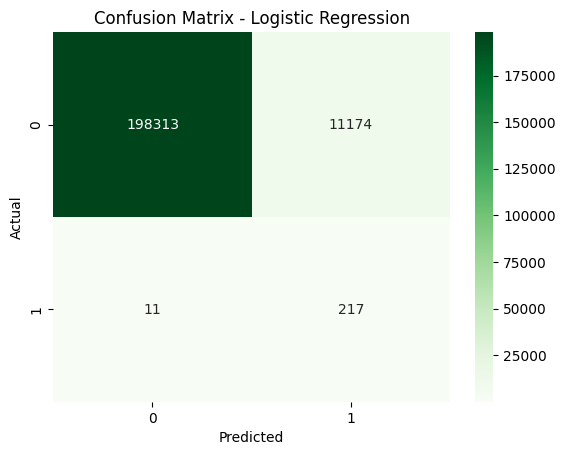

In [68]:
import matplotlib.pyplot as plt
import seaborn as sns

#Confusion matrix

conf_matrix_log = confusion_matrix(y_val, y_pred_lr)
sns.heatmap(conf_matrix_log, annot=True, fmt='d', cmap='Greens')
plt.title('Confusion Matrix - Logistic Regression')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [69]:
import os

# Create the folder if it doesn't already exist
os.makedirs('saved_models', exist_ok=True)


In [71]:
import joblib

joblib.dump(best_lr, 'saved_models/logistic_regression_model.pkl')

['saved_models/logistic_regression_model.pkl']

#SECTION 1: Model Architecture:



```
TODO: Insert an image with the Model architecture here.Replace the image Below
```
> <img src="https://miro.medium.com/v2/resize:fit:640/format:webp/1*v1ohAG82xmU6WGsG2hoE8g.png" alt="?" style="width:25px"/>




#Task: Define a function that creates models without and With specified Optimization techniques


**Basic Neural Network (No Optimization)**

In [74]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from sklearn.metrics import classification_report


In [77]:
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.regularizers import l2 # Corrected import statement
from tensorflow.keras.callbacks import EarlyStopping


# Build the model (Instance 1)
model_1 = Sequential([
    Dense(64, activation='relu', input_shape=(X_train_scaled.shape[1],)),
    Dense(32, activation='relu'),
    Dense(1, activation='sigmoid')
])

In [79]:
# Compile with defaults (no optimizer tuning)
model_1.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Train on balanced and scaled data (NO EarlyStopping)
history_1 = model_1.fit(
    X_train_scaled,
    y_train,
    epochs=10,  # keep short to avoid overfitting
    batch_size=32,
    validation_data=(X_val_scaled, y_val),
    verbose=1
)

Epoch 1/10
39279/39279 ━━━━━━━━━━━━━━━━━━━━ 123s 3ms/step - accuracy: 0.9474 - loss: 0.1239 - val_accuracy: 0.9529 - val_loss: 0.1093
Epoch 2/10
39279/39279 ━━━━━━━━━━━━━━━━━━━━ 116s 3ms/step - accuracy: 0.9694 - loss: 0.0715 - val_accuracy: 0.9904 - val_loss: 0.0380
Epoch 3/10
39279/39279 ━━━━━━━━━━━━━━━━━━━━ 146s 3ms/step - accuracy: 0.9732 - loss: 0.0631 - val_accuracy: 0.9641 - val_loss: 0.0877
Epoch 4/10
39279/39279 ━━━━━━━━━━━━━━━━━━━━ 132s 3ms/step - accuracy: 0.9762 - loss: 0.0573 - val_accuracy: 0.9865 - val_loss: 0.0411
Epoch 5/10
39279/39279 ━━━━━━━━━━━━━━━━━━━━ 135s 3ms/step - accuracy: 0.9778 - loss: 0.0535 - val_accuracy: 0.9689 - val_loss: 0.0808
Epoch 6/10
39279/39279 ━━━━━━━━━━━━━━━━━━━━ 136s 3ms/step - accuracy: 0.9791 - loss: 0.0508 - val_accuracy: 0.9908 - val_loss: 0.0278
Epoch 7/10
39279/39279 ━━━━━━━━━━━━━━━━━━━━ 151s 3ms/step - accuracy: 0.9802 - loss: 0.0482 - val_accuracy: 0.9840 - val_loss: 0.0411
Epoch 8/10
39279/39279 ━━━━━━━━━━━━━━━━━━━━ 128s 3ms/step - ac

In [80]:
# Predict on validation set
y_pred_nn_1 = (model_1.predict(X_val_scaled) > 0.5).astype("int32")

# Evaluate
print("Classification Report - Basic Neural Network (Instance 1):")
print(classification_report(y_val, y_pred_nn_1))


6554/6554 ━━━━━━━━━━━━━━━━━━━━ 9s 1ms/step
Classification Report - Basic Neural Network (Instance 1):
              precision    recall  f1-score   support

           0       1.00      0.99      0.99    209487
           1       0.08      0.94      0.14       228

    accuracy                           0.99    209715
   macro avg       0.54      0.96      0.57    209715
weighted avg       1.00      0.99      0.99    209715



In [82]:
model_1.save('saved_models/nn_instance1_basic.keras')


# Task: Print out the Final Model Accuracy and plot the Loss curve

In [ ]:
def loss_curve_plot(None):
  epochs = None
  plt.plot(epochs, loss, 'bo', label='Training loss')
  plt.plot(epochs, val_loss, 'r', label='Validation loss')
  plt.title('Training and Validation Loss')
  plt.xlabel('Epochs')
  plt.ylabel('Loss')
  plt.legend()
  plt.show()

# SECTION 2: Optimization and Regularization Combinations
At this point you should now create models that combine various optimization techniques
As done before make sure to plot out the loss curve and the accuracy and loss in verbose

In [ ]:
#TODO:
model_2 = define_model('Adam', None)
loss_curve_plot(model_2):
#print out confusion matrix and error analysis metrics after the cell

In [ ]:
#TODO:
model_3 = define_model('RMSPop',None)
loss_curve_plot(model_3):
#print out confusion matrix and error analysis metrics after the cell

In [ ]:
#TODO:
model_4 = define_model(None)
loss_curve_plot(model_4):
#print out confusion matrix and error analysis metrics after the cell

#Task: Make Predictions using the best saved model


Create a confusion Matrix and F1 score for both Models. Ensure outputs for the cells are visible

Finally, Make predictions using the best model. By the time you get to this cell you may realise at some point you needed to save the model so that you cal load it later

In [ ]:
def make_predictions(model_path, X):

    # Load the model
    model = load_model(None)
    # Make predictions
    predictions = None
    # Convert probabilities to binary labels (0 or 1)

    return predictions

#Modify the code appropriately

In [ ]:
model_path = None
make_predictions(None)

Congratulations!!
